In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd

# Create a new dataframe to hold all the metrics from all the neighborhoods
neighborhood_metrics = pd.DataFrame()

#Get all neighborhoods in an array and add it to the neighborhood_metrics
neighborhood_shapes = gpd.read_file("Neighborhoods_.geojson")
neighborhood_metrics["neighborhood"] = neighborhood_shapes["hood"]

# When you add your metric column, make sure it's aligned to the way the neighborhoods are stored in neighborhood_metrics

## Asbestos

In [38]:
asbestos_data = pd.read_csv("data_with_neighborhoods/Asbestos_WithNeighborhood.csv")

reads data from data_with_neighborhoods/Asbestos_WithNeighborhood.csv

In [39]:
asbestos_query = asbestos_data["job_complete"] == "f"
contains_asbestos = asbestos_data[asbestos_query]

creates another data set that only incorporates buildings in which asbestos is untreated

#### The 5 neighborhoods with the most buildings with asbestos:

In [40]:
pd.DataFrame(contains_asbestos["neighborhood"].value_counts().head(5))

,neighborhood
Central Business District,186
West Oakland,66
Squirrel Hill North,35
Allegheny Center,32
Bloomfield,31


#### The 5 nieghborhoods with the least amount of asbestos:

In [41]:
pd.DataFrame(contains_asbestos["neighborhood"].value_counts().tail(5))

,neighborhood
East Carnegie,1
Terrace Village,1
Regent Square,1
Spring Garden,1
Beltzhoover,1


#### Bar graph of all asbestos quanities per neighborhood:

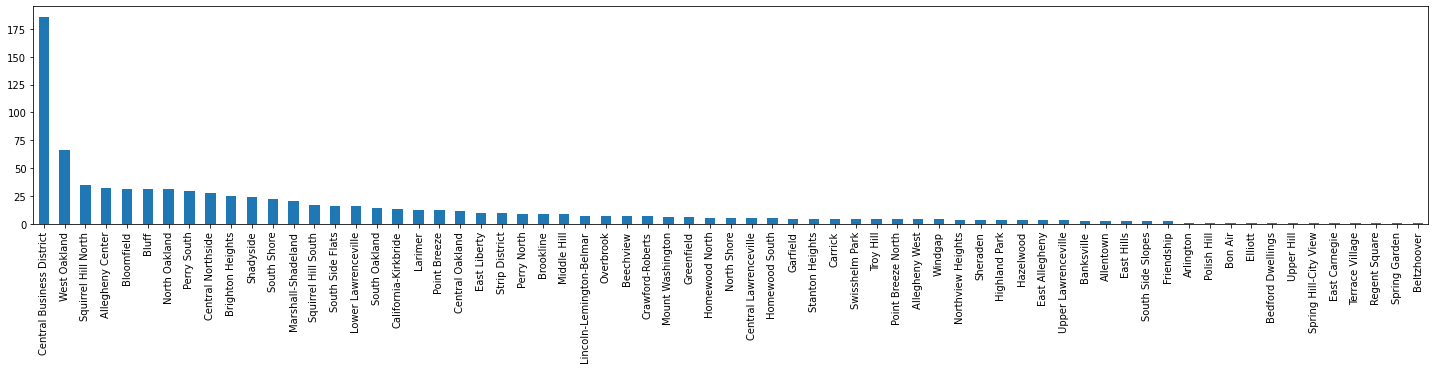

In [42]:
contains_asbestos["neighborhood"].value_counts().plot.bar(figsize = (25,4))

#### Scoring for Asbestos:
Based off of the percentage of untreated asbestos to total buildings checked for asbestos

This prevents the data from being too skewed, since if a neighborhood had more buildings checked, then it would clearly have a higher amount of asbestos found

Any null value is replaced with a 0, since that neighborhood had no asbestos found

In [43]:
scores = contains_asbestos["neighborhood"].value_counts().sort_index()/asbestos_data["neighborhood"].value_counts().sort_index()*100
scores = scores.fillna(0)
scores = scores.round()
scores = scores.sort_values(0,False)

The scores are then stored into a DataFrame to create a map for the data

In [44]:
df_scores = pd.DataFrame(scores)
df_scores = df_scores.reset_index()
df_scores.columns = ["neighborhood","score"]
df_scores

,neighborhood,score
0,Regent Square,100.0
1,Arlington,100.0
2,Polish Hill,100.0
3,Windgap,67.0
4,North Shore,62.0
...,...,...
80,Chateau,0.0
81,Crafton Heights,0.0
82,Hays,0.0
83,Duquesne Heights,0.0


#### Map of Asbestos Scores:
Finally, merging the scores DataFrame with the Map DataFrame and creating the Score's Map

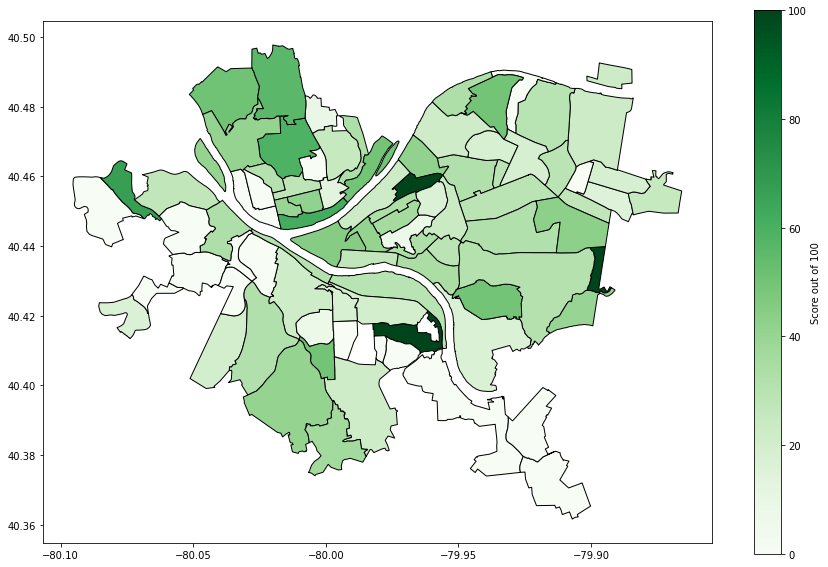

In [45]:
scores_map = neighborhood_shapes.merge(df_scores, how = 'left', left_on = 'hood', right_on = 'neighborhood')
scores_map.plot(column = 'score', figsize = (15,10), cmap = 'Greens', edgecolor = 'black', legend = True, legend_kwds={'label': "Score out of 100"})

## Restaurant Inspections

In [46]:
# Load data
restaurantInspections = pd.read_csv("data_with_neighborhoods/restaurantInspections_WithNeighborhood.csv")

# Use a mask to extract the rows from the data where a building fails an inspection
restaurant_fail_mask = restaurantInspections["placard_desc"]!="Inspected & Permitted"
restaurant_fail = restaurantInspections[restaurant_fail_mask]

# Groupby neighborhood and count the number of instances per neighborhood
# Because the only data in restaurant_fail is failed results, this count is the number of failed inspections
restaurant_fail_count = restaurant_fail.groupby("neighborhood")["placard_desc"].count()

# Generate total count in a similar way
restaurant_total_count = restaurantInspections.groupby("neighborhood")["placard_desc"].count()

# Create a new dictionary. 
# Using a dictionary can ensure that none of the information is misaligned by neighborhood,
# because dictionaries are unordered
resturaunt_fail_proportion_dict = {}

# Add all the fail counts into the dictionary under their neighborhood
for x in zip(restaurant_fail_count.index,restaurant_fail_count):
    resturaunt_fail_proportion_dict[x[0]] = x[1]
    
# Divide all fail counts by the total counts
for x in zip(restaurant_total_count.index,restaurant_total_count):
    # Some neighborhoods have no restaurants that fail, which means they won't show up in the 
    # restaurant_fail_count. For those, put zero in the dictionary in its place
    if (x[0] in resturaunt_fail_proportion_dict):
        # Assign result to result divided by total count
        resturaunt_fail_proportion_dict[x[0]] = resturaunt_fail_proportion_dict[x[0]] / x[1]
    else:
        resturaunt_fail_proportion_dict[x[0]] = 0
    
# Create a new array for the restaurant metric to be added to metrics
restaurant_metric = []

for neighborhood in neighborhood_metrics["neighborhood"]:
    
    # Some neighborhoods don't have any results at all
    if(neighborhood in resturaunt_fail_proportion_dict):
        # append the result for that neighborhood into the new array
        restaurant_metric.append(resturaunt_fail_proportion_dict[neighborhood])
    else:
        restaurant_metric.append(float("NaN")) # Only way to pass NaN manually
    
# Add metric column to list of metrics
neighborhood_metrics["restaurant_metric"] = restaurant_metric

print(neighborhood_metrics.sort_values("restaurant_metric"))
                                                                            

       neighborhood  restaurant_metric
70        Knoxville           0.000000
38     West Oakland           0.000000
87           Esplen           0.000000
45  Terrace Village           0.000000
80          Windgap           0.000000
..              ...                ...
84  Crafton Heights           0.052632
20    New Homestead                NaN
54   Swisshelm Park                NaN
86   Chartiers City                NaN
88        Ridgemont                NaN

[90 rows x 2 columns]


/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Fire Data

In [47]:
fireData = pd.read_csv("fire.csv")

Reads the fire data into a variable called fireData

In [48]:
df = fireData[['neighborhood', 'alarms']].groupby(by='neighborhood')

Creates a dataframe of the fire data, keeping only the neighborhood and alarm column
and then grouping all the alarm values into which neighborhood they belong into

In [49]:
df1 = df.sum().sort_values(by='alarms')

The values of each neighborhood are all added together, and then sorted by the value in their alarms

In [50]:
df1.head()

,alarms
neighborhood,
Ridgemont,1
Mount Oliver Borough,2
New Homestead,2
Hays,3
Regent Square,3


This shows the 5 neighborhoods with the least amount of fire alarms

In [51]:
df1.tail()

,alarms
neighborhood,
Lincoln-Lemington-Belmar,120
Squirrel Hill South,124
South Side Flats,126
Central Business District,153
Carrick,162


This shows the 5 neighborhoods with the most amount of fire alarms

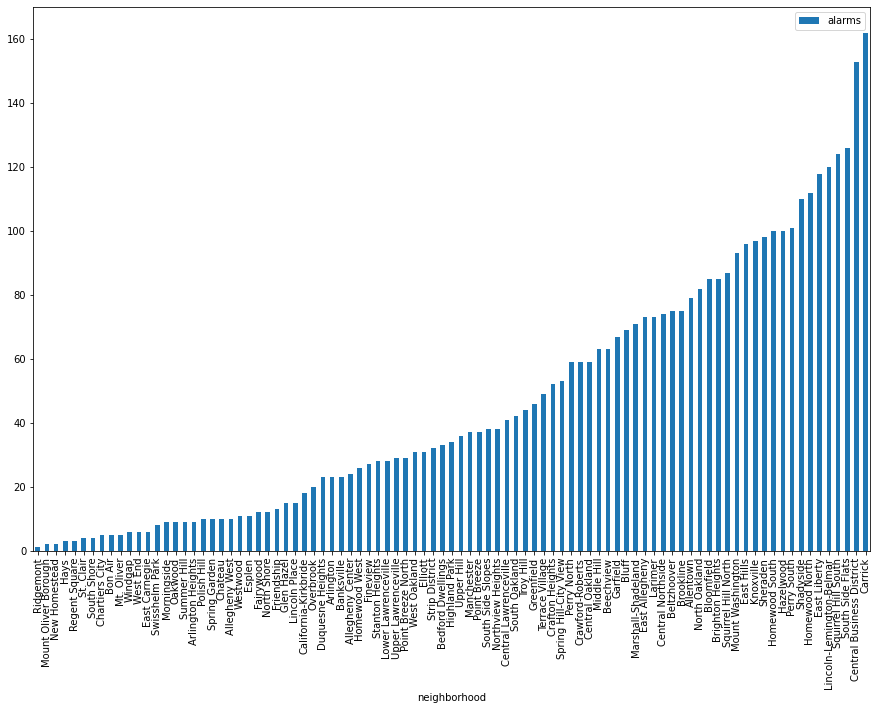

In [52]:
df1.plot(kind = 'bar', figsize=(15,10))

This is the data from all the neighborhoods plotted into an ascending bar graph

In [53]:
alarms = fireData.groupby("neighborhood").sum()['alarms']
alarms.sort_values(ascending=False)

neighborhood
Carrick                      162
Central Business District    153
South Side Flats             126
Squirrel Hill South          124
Lincoln-Lemington-Belmar     120
                            ... 
Regent Square                  3
Hays                           3
New Homestead                  2
Mount Oliver Borough           2
Ridgemont                      1
Name: alarms, Length: 91, dtype: int64

Sorts the fire alarm dataset by the number of alarms per neighborhood

In [54]:
neighborhoods = gpd.read_file("Neighborhoods/Neighborhoods_.shp")

Creates the Pittsburgh dataset 

In [55]:
alarms_map = neighborhoods.merge(alarms, how='left', left_on='hood', right_on='neighborhood')

Merges my dataset with the neighborhood dataset 

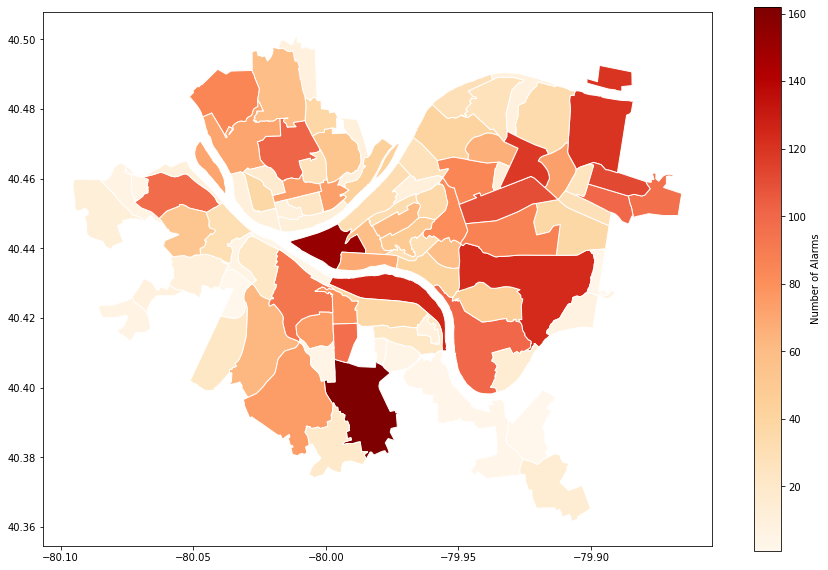

In [56]:
alarms_map.plot(column='alarms', figsize=(15,10), cmap='OrRd',edgecolor="white",legend=True,
               legend_kwds={'label': "Number of Alarms"})

Plots the data, producing a map of Pittsburgh sorted by number of fire alarms that occured in each neighborhood

In [68]:

final_map1 = pd.concat([alarms_map,scores_map])
finaldata = final_map1.groupby("neighborhood").sum()['alarms','score']
finaldata

KeyError: ('alarms', 'score')